# Model Explainability

The growing availability of big data has increased the benefits of using complex models, so data scientists often have to choose between accuracy and interpretability of a model’s output. Adding explainability methods to models that are not easily understood helps:
- Ensure algorithmic fairness
- Identify potential bias in the training data
- Support an overall better understanding of the process being modeled.

These methods are able to give insight into why your model generates specific outputs. This is a useful trait in highly regulated industries when it's necessary to know why a particular instance was classified in a certain way (e.g., determining why a model approved or denied a customer loan).

Let's start by loading in the dataset. This notebook was created using the output from the [simple summaries feature engineering noteboook](03-feature-engineering-summaries.ipynb). It is recommended that you run this notebook first to follow along with the prose.

In [1]:
import pandas as pd
import os.path
from sklearn import model_selection

df = pd.read_parquet(os.path.join("data", "features.parquet"))
df

,index,label,no_punct,number_words,mean_wl,max_wl,min_wl,pc_10_wl,pc_90_wl,upper,stop_words
0,0,legitimate,34,124,4.604839,14,1,2.0,8.0,22,64
1,1,legitimate,16,87,4.896552,16,1,2.0,8.4,10,46
2,2,legitimate,23,139,4.330935,12,1,2.0,8.0,24,74
3,3,legitimate,17,94,4.500000,13,1,2.0,9.0,13,49
4,4,legitimate,12,80,4.375000,9,2,2.0,7.0,11,46
...,...,...,...,...,...,...,...,...,...,...,...
39995,19995,spam,10,52,4.211538,11,1,2.0,7.0,8,25
39996,19996,spam,8,66,4.545455,13,1,2.0,8.5,6,34
39997,19997,spam,11,52,4.384615,12,1,2.0,7.0,10,20
39998,19998,spam,15,95,3.926316,12,1,2.0,6.0,9,54


We have to edit some of the fields in our dataset in order to comply with the explainability method's inputs. Because models don't understand written language in the ways humans do, we will translate the `label` variable into [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) using a [One Hot encoder](https://en.wikipedia.org/wiki/One-hot). The output will be two columns, `spam` and `legitimate` , where the labels are either 0 or 1 to identify each type of email. Having two columns is redundant, as a label of 0 for `legitimate` would be the equivalent of a label of 1 for `spam` column, so we will drop one column (`spam`, specifically but arbitrarily chosen) in order to reduce redundancy. 

In [2]:
import numpy as np

df_with_dummies = pd.get_dummies(df['label'])
data = pd.concat([df, df_with_dummies], axis=1)
data.drop(['spam', 'label'], inplace = True, axis=1)

In [3]:
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]

data = data[cols]
data.iloc[:,2:data.shape[1]]

,no_punct,number_words,mean_wl,max_wl,min_wl,pc_10_wl,pc_90_wl,upper,stop_words
0,34,124,4.604839,14,1,2.0,8.0,22,64
1,16,87,4.896552,16,1,2.0,8.4,10,46
2,23,139,4.330935,12,1,2.0,8.0,24,74
3,17,94,4.500000,13,1,2.0,9.0,13,49
4,12,80,4.375000,9,2,2.0,7.0,11,46
...,...,...,...,...,...,...,...,...,...
39995,10,52,4.211538,11,1,2.0,7.0,8,25
39996,8,66,4.545455,13,1,2.0,8.5,6,34
39997,11,52,4.384615,12,1,2.0,7.0,10,20
39998,15,95,3.926316,12,1,2.0,6.0,9,54


We split the data into training and testing sets, as in other notebooks, using the `random_state` parameter to ensure that the data is split in the same way as it was when we fit the model.

In [4]:
from sklearn import model_selection

train, test = model_selection.train_test_split(data, random_state=43)

We'll load in the model pipeline created in previous notebooks, fit the model, and generate predictions.

In [5]:
# loading in feature extraction pipeline
import pickle

# loading model
filename = 'model.sav'
model = pickle.load(open(filename, 'rb'))

In [6]:
# fit model
model.fit(X=train.iloc[:,2:train.shape[1]], y=train["legitimate"])

# generate predictions
y_preds = model.predict(test.iloc[:,2:test.shape[1]])

Our model has now made a classification prediction for each of the test data points. However, we don't have much intuition as to how the model chose to classify these values. Was it based off of the amount of words in each email? Number of punctuation points? Explainability methods exist to offer ways to explore the decision making process of black-box models such as this one. Let's see if we can figure out why this prediction was made.

## SHAP
One type of explainability method is [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html), or SHapley Additive exPlanations, where a local prediction is explained by displaying each feature's  contribution to the prediction. The output of a SHAP method is a linear model created for a particular instance. The method below uses KernelSHAP, which is just used as a black-box SHAP method for an arbitrary classification model. 

In [7]:
import alibi
from alibi.explainers import KernelShap
import shap

predict_fn = model.predict_proba
shap_explainer = KernelShap(predict_fn)

shap_explainer.fit(test.iloc[:5,2:test.shape[1]]) # only using a subsection of the data to fit
                                                  # to avoid unnecessary computational
                                                  # stress 

KernelShap(meta={
    'name': 'KernelShap',
    'type': ['blackbox'],
    'task': 'classification',
    'explanations': ['local', 'global'],
    'params': {
        'groups': None,
        'group_names': None,
        'weights': None,
        'kwargs': {},
        'summarise_background': False
    }
})

In [8]:
shap_explanation = shap_explainer.explain(test.iloc[:,2:test.shape[1]], l1_reg=False)

### Visualizations
After initializing the explainer, we can look at both global and local explanation methods. We'll use a `force_plot` visualization to better understand the local linear model generated by SHAP. This plot shows which features contributed to making the prediction, and to what extent they moved the prediction from the base value (output of model if no inputs are given) to the output value for that instance. 

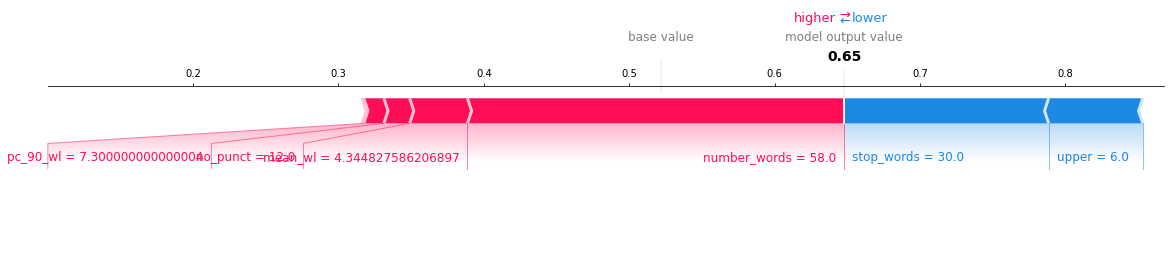

In [9]:
idx = 0
instance = test.iloc[idx,2:test.shape[1]]
class_idx = y_preds[idx]
feature_names = list(test.columns[2:])

shap.force_plot(
    shap_explainer.expected_value[class_idx],
    shap_explanation.shap_values[class_idx][idx, :],
    instance,
    feature_names = feature_names,
    matplotlib=True
)

We can see from the plot that the `stop_words` and `number_words` features had the biggest influence on the model's decision to classify this instance. However, it's important to note that this is a local explanation. Other instances will have different weights for each feature, so we cannot generalize this output to the whole model. We could look at other explainability methods such as [counterfactuals](https://christophm.github.io/interpretable-ml-book/counterfactual.html) to find out what changes to the input would create the correct classification. 

We see what influenced this instance the most, but what about the overall model? SHAP also offers global explanations, which can be viewed best by a `summary_plot`.

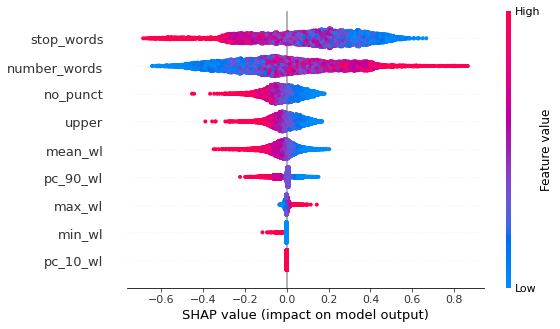

In [10]:
shap.summary_plot(shap_explanation.shap_values[idx], 
                  test.iloc[:,2:test.shape[1]],  
                  feature_names = feature_names)

This plot shows the total sum of each feature's SHAP value for each of the instances in `x_test` with a class `0` (not legitimate, aka spam). Features with the highest impact are at the top of the plot. We can see here again that `stop_words` and `number_words` are the two strongest features; as the values of the features increase, their impact also increases and the model is more likely to predict class `0`.  

# Conclusion
In the end, explainers are not built to fix problems in models, but rather expose them. Understanding how black-box models make decisions before launching them into production helps ensure transparency and avoid unconscious bias. 